In [6]:
import pandas as pd

df = pd.read_csv('../data/processed/cleaned_data.csv')


In [10]:
df['Adj_Close_Change'] = df.groupby('Company')['Close/Last'].pct_change() * 100
df['Volume_Change'] = df.groupby('Company')['Volume'].pct_change() * 100

df = df.dropna(subset=['Adj_Close_Change', 'Volume_Change'])


In [11]:
print(df.columns)

Index(['Company', 'Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low',
       'Price_Range', 'Daily_Price_Change', 'Adj_Close_Change',
       'Volume_Change'],
      dtype='object')


In [13]:
from sklearn.ensemble import IsolationForest

features = df[['Adj_Close_Change', 'Volume_Change']]

iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(features)

anomaly_scores = -iso_forest.decision_function(features)
df['Anomaly_Score'] = anomaly_scores

/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_82096/2037297929.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Anomaly_Score'] = anomaly_scores


In [15]:
lookback_period = 7
scaling_factor = 1.5

df['Dynamic_Threshold'] = df.groupby('Company')['Anomaly_Score'].transform(
    lambda x: x.rolling(window=lookback_period, min_periods=1).max() * scaling_factor
)
df['Anomaly'] = (df['Anomaly_Score'] > df['Dynamic_Threshold']).astype(int)


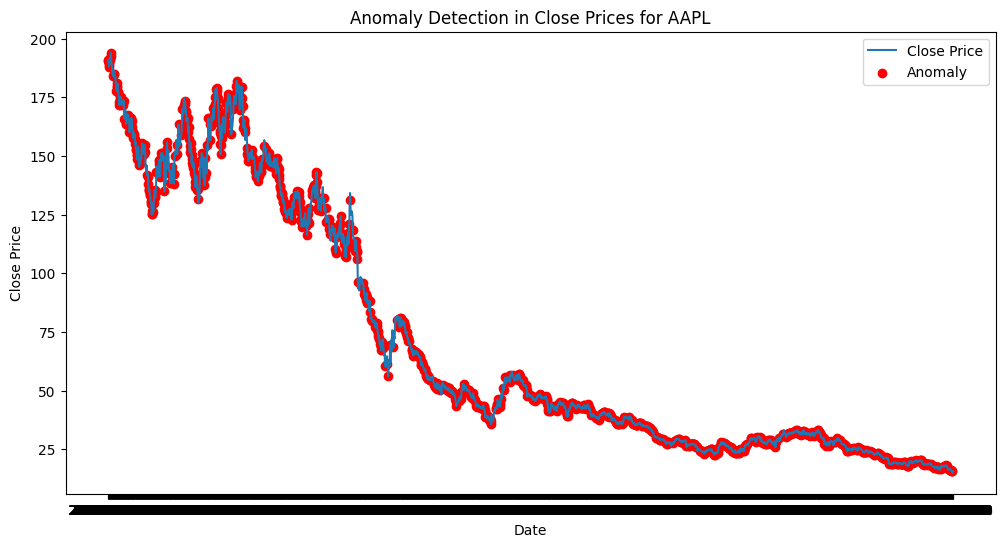

In [17]:
import matplotlib.pyplot as plt

company_data = df[df['Company'] == 'AAPL']

plt.figure(figsize=(12, 6))
plt.plot(company_data['Date'], company_data['Close/Last'], label='Close Price')
plt.scatter(company_data[company_data['Anomaly'] == 1]['Date'], 
            company_data[company_data['Anomaly'] == 1]['Close/Last'],
            color='red', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Anomaly Detection in Close Prices for AAPL')
plt.legend()
plt.show()
